# Debugging Practicum II
Once again, we'll be spending time debugging example code. In this case, we're performing a statistical power analysis by simulating data from idealized experiments. Below, you are given two functions:

1. `run_expt`: generates synthetic data for the idealized experiment and performs a statistical hypothesis test.
4. `calc_power`: calculates the power of the statistical procedure defined by a function passed to it.

## Model
Our idealized experiment works as follows: assume

- a spiking single unit described as a Poisson process with baseline rate $\lambda_0$
- observed for a duration $T_0$
- when presented with a stimulus, the unit increases its firing rate to $\alpha \lambda_0$
- and is observed for a duration $T$
- from one trial to the next, log firing rates vary based on a percentage of the mean value:

  $$ 
  \log \lambda_i = \log \lambda + \epsilon \log \lambda
  $$

  with $\epsilon$ normally distributed with mean 0, standard deviation $\sigma$ and $\lambda$ equal to either the baseline or stimulus rate, as appropriate

Then, given observed spike counts generated from Poisson distributions based on these rates and observation durations, we calculate (empirical) firing rates for the stimulus $\hat{\lambda}_i$ and baseline $\hat{\lambda}_{0i}$  for each trial and perform a paired t-test of the hypothesis that they are the same.

```{admonition} Exercise
Fix the code. Three strategies I recommend:
  1. Pick (multiple sets of) input values with obvious correct answers and use these for testing.
  1. Using sensible values, break apart the functions to see how pieces of them should work. This way, you can plot as you go, and it's a little easier than using the debugger.
  1. Use the debugger to step into the code and plot the calculated quantities at each stage of the code. Do they make sense?
```

## Code listing:

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import seaborn as sns
np.random.seed(12345)  # for reproducibility

In [ ]:
def run_expt(baseline, effect, Tbaseline, Tstim, trial_noise_std, Ntrials):
    # run a single synthetic experiment, return p-value for paired t-test
    # of baseline vs stim spike rate
    
    # random rates
    baseline_rates = np.exp(np.log(baseline) * 
                    (trial_noise_std * np.random.randn(Ntrials)))
    stim_rates = np.exp(np.log(effect * baseline) * 
                    (1 + trial_noise_std * np.random.rand(Ntrials)))
    
    # random counts
    baseline_counts = stats.poisson.rvs(baseline_rates)
    stim_counts = stats.poisson.rvs(stim_rates)
    
    # observed rates
    obs_baseline_rates = baseline_counts / Tbaseline
    obs_stim_rates = stim_counts / Tbaseline
    
    # test
    return stats.ttest_rel(obs_baseline_rates, obs_stim_rates)

In [ ]:
def calc_power(alpha, Nexpt, exptfun, *args):
    # calculate power for an experiment defined by false positive rate alpha and repeated Nexpt times
    # exptfun returns an object with a pvalue
    # args are passed on to exptfun
    
    pvals = np.array([exptfun(*args).pvalue for _ in range(Nexpt)])
    
    return np.mean(pvals < alpha)

## Solution:

```{toggle}
1. In `run_expt`, the calculation of `baseline_rates` should use `1 +` in the second factor, as in the line below.
1. The calculation of `stim_rates` in `run_expt` should use `randn`, not `rand`
1. In `run_expt`, the calculation of `baseline_counts` and `stim_counts` should use Poisson parameters proportional to observation times `Tbaseline` and `Tstim`, respectively.
1. The calculation of `obs_stim_rates` in `run_expt` should use `Tstim` rather than `Tbaseline`.
```

### Example strategy: break apart functions:
Here, we can pick some sensible numbers and show how sections of the code should work.

In [2]:
# define some numbers
baseline = 20.  # firing rate in Hz
Tbaseline = 1.
Tstim = 1.
effect = 2  # fractional change from baseline
trial_noise_std = 0.0  # trial-to-trial noise as a percentage
Ntrials = 500  # number of trials for each stimulus
Nexpt = 1000  # number of synthetic experiments to conduct
alpha = 0.05  # nominal false positive rate

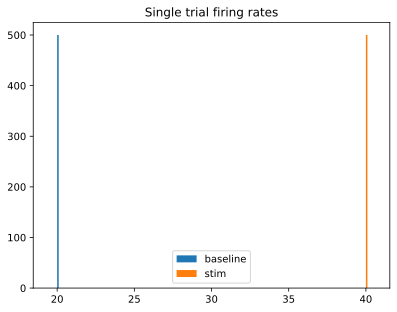

In [3]:
baseline_rates = np.exp(np.log(baseline) * 
                (1 + trial_noise_std * np.random.randn(Ntrials)))
stim_rates = np.exp(np.log(effect * baseline) * 
                (1 + trial_noise_std * np.random.randn(Ntrials)))

plt.hist(baseline_rates, label='baseline');
plt.hist(stim_rates, label='stim');
plt.legend();
plt.title('Single trial firing rates');

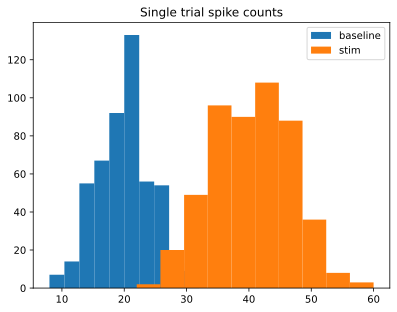

In [4]:
baseline_counts = stats.poisson.rvs(baseline_rates * Tbaseline)
stim_counts = stats.poisson.rvs(stim_rates * Tstim)

plt.hist(baseline_counts, label='baseline');
plt.hist(stim_counts, label='stim');
plt.legend();
plt.title('Single trial spike counts');

In [5]:
obs_baseline_rates = baseline_counts / Tbaseline
obs_stim_rates = stim_counts / Tstim

tstat, pval = stats.ttest_rel(obs_baseline_rates, obs_stim_rates)
print(tstat, pval)
print(pval < alpha)

-62.191816367004016 3.41747897325314e-237
True


### Corrected functions

In [6]:
def run_expt(baseline, effect, Tbaseline, Tstim, trial_noise_std, Ntrials):
    # run a single synthetic experiment, return p-value for paired t-test
    # of baseline vs stim spike rate
    
    # random rates
    baseline_rates = np.exp(np.log(baseline) * (1 + trial_noise_std * np.random.randn(Ntrials)))
    stim_rates = np.exp(np.log(effect * baseline) * (1 + trial_noise_std * np.random.randn(Ntrials)))
    
    # random counts
    baseline_counts = stats.poisson.rvs(baseline_rates * Tbaseline)
    stim_counts = stats.poisson.rvs(stim_rates * Tstim)
    
    # observed rates
    obs_baseline_rates = baseline_counts / Tbaseline
    obs_stim_rates = stim_counts / Tstim
    
    # test
    return stats.ttest_rel(obs_baseline_rates, obs_stim_rates)


def calc_power(alpha, Nexpt, exptfun, *args):
    # calculate power for an experiment defined by false positive rate alpha and repeated Nexpt times
    # exptfun returns an object with a pvalue
    # args are passed on to exptfun
    
    pvals = np.array([exptfun(*args).pvalue for _ in range(Nexpt)])
    
    return np.mean(pvals < alpha)

### Test case:

In [7]:
alpha = 0.05
Nexpt = 1000
baseline = 20.  # firing rate in Hz
Tbaseline = 1.
Tstim = 1.
effect = 1.2  # fractional change from baseline
trial_noise_std = 0.10  # trial-to-trial noise as a percentage
Ntrials = 50  # number of trials for each stimulus

calc_power(alpha, Nexpt, run_expt, baseline, effect, Tbaseline, Tstim, trial_noise_std, Ntrials)

0.657